In [1]:
%matplotlib inline

In [2]:
from pylab import *
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
import h5py, scipy.interpolate, ellipsoids
from scipy.spatial.transform import Rotation
from density_center import def_dc
from astropy.cosmology import Planck15
G = 4.498317481097514e-06

In [3]:
# Load Illustris-TNG snapshot
particle_data = h5py.File('data/subhalo_489100.hdf5', 'r')

# Simumation parameters
h0 = 0.6774
snap, z = loadtxt('data/snapshots.dat', unpack=True)
snap = snap.astype(int)
a = 1/(1+z)
t = Planck15.age(z).value

# Dictionary of particle types
particle_types = {}
particle_types['gas']   = '0'
particle_types['dm']    = '1'
particle_types['stars'] = '4'
particle_types['bhs']   = '5'

# First get the global coordinate system
def get_half_mass_radius(m, r):
    i = argsort(r)
    r_sorted = r[i]
    m_sorted = m[i]
    m_cum = cumsum(m_sorted)
    j = searchsorted(m_cum, m_cum[-1]/2)
    return r_sorted[j] # close enough
def get_transformation(m, X, V=None):
    V_center = None
    if not V is None: X_center, V_center = def_dc(m, X, V)
    else: X_center = def_dc(m, X)
    X_shifted = X - X_center
    r = linalg.norm(X_shifted, axis=1)
    rh = get_half_mass_radius(m, r)
    mask = r < 2*rh
    Q = ellipsoids.quadrupole_tensor(*X_shifted[mask].T, m[mask])
    eigenvalues, eigenvectors = linalg.eig(Q)
    R = ellipsoids.rotation_matrix_from_eigenvectors(eigenvectors, eigenvalues)
    return X_center, V_center, R, mask
i, snapshot = len(snap)-1, snap[-1]
m = particle_data[str(snapshot)][particle_types['stars']]['Masses'][...]
X = particle_data[str(snapshot)][particle_types['stars']]['Coordinates'][...] * a[i] / h0
X_center_glob, _, R_glob, _ = get_transformation(m, X)

In [4]:
# Load our approximation
snapshot, t, \
  phi_inertia, theta_inertia, M_disk, a_mn, b_mn, \
  rho_0_nfw, b_nfw \
  = loadtxt('results/subhalo_489100_parameters_processed.dat', unpack=True)

In [5]:
# Load orbit
orbital_data = loadtxt('data/part-2266.dat', skiprows=13, usecols=[0, 11, 12, 13])
t_orbit = t[-1] - orbital_data[:, 0]  / 1000 # Myr -> Gyr; in the file the time goes backward
X_orbit = orbital_data[:, 1:] / 1000 # pc -> kpc

In [6]:
# Get the stars' coordinate along its orbit in times corresponding to the snapshots
X_orbit_interp = scipy.interpolate.interp1d(t_orbit, X_orbit, axis=0, bounds_error=False)
X_orbit_snaps = X_orbit_interp(t)

In [7]:
# Calculate the N-body gravity at the particle's interpolated location, at each snapshot
pot_nbody = zeros(len(snap))
acc_nbody = zeros((len(snap), 3))
for i in range(len(snap)):
    if isnan(X_orbit_snaps[i,0]): continue
    snapshot = snap[0] + i

    m_dm  = particle_data[str(snapshot)][particle_types['dm']]['Masses'][...]
    X_dm  = particle_data[str(snapshot)][particle_types['dm']]['Coordinates'][...] * a[i] / h0
    m_gas = particle_data[str(snapshot)][particle_types['gas']]['Masses'][...]
    X_gas = particle_data[str(snapshot)][particle_types['gas']]['Coordinates'][...] * a[i] / h0
    m_stars = particle_data[str(snapshot)][particle_types['stars']]['Masses'][...]
    X_stars = particle_data[str(snapshot)][particle_types['stars']]['Coordinates'][...] * a[i] / h0
    m = hstack([m_dm, m_gas, m_stars])
    X = vstack([X_dm, X_gas, X_stars])

    X = (R_glob @ (X - X_center_glob).T).T
    X_center_halo = def_dc(m, X)
    X = X - X_center_halo

    j_particle_coords = X

    i_particle_coords = X_orbit_snaps[i,:]
    R = i_particle_coords - j_particle_coords
    r = linalg.norm(R, axis=1)
    pot_nbody[i] = sum(-G*m/r)
    acc_nbody[i] = sum(-G*m[:,None]*R/r[:,None]**3, axis=0)
    print(f'{i} out of {len(snap)}')

12 out of 75
13 out of 75
14 out of 75
15 out of 75
16 out of 75
17 out of 75
18 out of 75
19 out of 75
20 out of 75
21 out of 75
22 out of 75
23 out of 75
24 out of 75
25 out of 75
26 out of 75
27 out of 75
28 out of 75
29 out of 75
30 out of 75
31 out of 75
32 out of 75
33 out of 75
34 out of 75
35 out of 75
36 out of 75
37 out of 75
38 out of 75
39 out of 75
40 out of 75
41 out of 75
42 out of 75
43 out of 75
44 out of 75
45 out of 75
46 out of 75
47 out of 75
48 out of 75
49 out of 75
50 out of 75
51 out of 75
52 out of 75
53 out of 75
54 out of 75
55 out of 75
56 out of 75
57 out of 75
58 out of 75
59 out of 75
60 out of 75
61 out of 75
62 out of 75
63 out of 75
64 out of 75
65 out of 75
66 out of 75
67 out of 75
68 out of 75
69 out of 75
70 out of 75
71 out of 75
72 out of 75
73 out of 75
74 out of 75


In [8]:
def miyamoto_nagai(M, a, b, phi, theta, pos):
    # Construct new z-axis from the angles
    cos_theta = cos(theta)
    sin_theta = sqrt(1-cos_theta**2)
    cos_phi   = cos(phi)
    sin_phi   = sqrt(1-cos_phi*cos_phi)
    old_z_axis = array([cos_phi*sin_theta, sin_phi*sin_theta, cos_theta])

    # Construct rotation
    rot_vec = array([old_z_axis[1], -old_z_axis[0], 0])
    rot_vec /= linalg.norm(rot_vec)
    rot_angle = arccos(old_z_axis[-1] / linalg.norm(old_z_axis))
    rot_vec *= rot_angle
    rot = Rotation.from_rotvec(rot_vec)

    # Rotate the position vector
    new_pos = rot.apply(pos)

    # Calculate acceleration in new frame
    acc_in_rotated_frame = empty(3)
    z_tmp  = sqrt(new_pos[2]**2 + b**2)
    r2_tmp = new_pos[0]**2 + new_pos[1]**2 + (z_tmp + a)**2
    r_tmp  = sqrt(r2_tmp)
    pot = - G*M / r_tmp
    tmp = G*M / (r2_tmp*r_tmp)
    acc_in_rotated_frame[0] = - tmp * new_pos[0]
    acc_in_rotated_frame[1] = - tmp * new_pos[1]
    acc_in_rotated_frame[2] = - tmp * new_pos[2] * (z_tmp + a)/z_tmp;

    # Return to original frame
    return rot.inv().apply(acc_in_rotated_frame), pot

def nfw(rho_0, b, pos):
    r = linalg.norm(pos)
    tmp = -4*pi*G*rho_0*b**3*(log1p(r/b) - r/(b+r))/(r**3)
    pot = -4*pi*G*rho_0*b**3*log1p(r/b)/r
    return pos*tmp, pot

In [9]:
# Calculate the model gravity at the particle's interpolated location, at each snapshot
pot_model = zeros(len(snap))
acc_model = zeros((len(snap), 3))
for i in range(len(snap)):
    if isnan(X_orbit_snaps[i,0]): continue
    snapshot = snap[0] + i
    i_particle_coords = X_orbit_snaps[i,:]
    acc_nfw, pot_nfw = nfw(rho_0_nfw[i], b_nfw[i], i_particle_coords)
    acc_nm, pot_nm  = miyamoto_nagai(M_disk[i], a_mn[i], b_mn[i], phi_inertia[i], theta_inertia[i], i_particle_coords)
    acc_model[i] = acc_nfw + acc_nm
    pot_model[i] = pot_nfw + pot_nm

# Results: potential

Mean 0.16388618049604048
Standard deviation 0.14093708541076244


/home/meiron/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'relative difference')

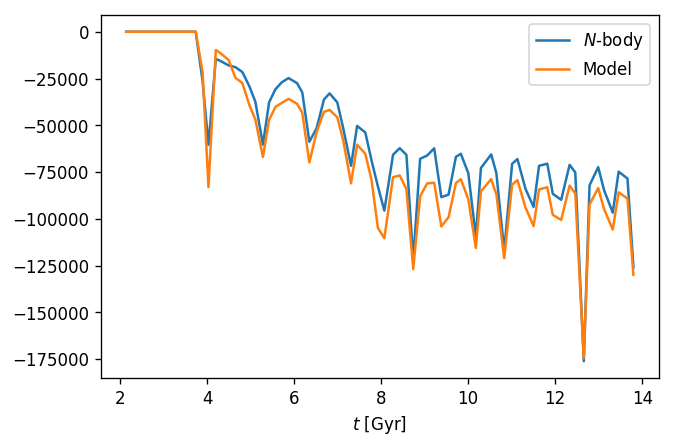

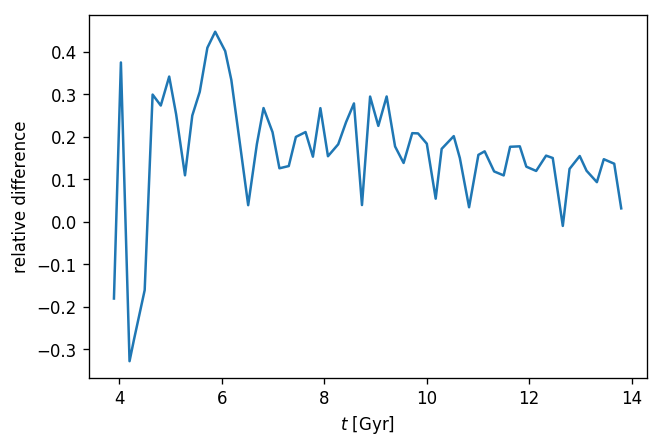

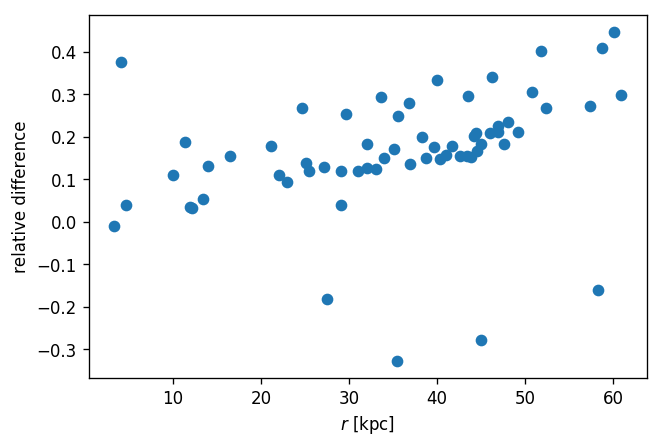

In [13]:
plot(t, pot_nbody)
plot(t, pot_model)
legend(('$N$-body', 'Model'))
xlabel('$t$ [Gyr]')
figure()
relative_diff = (pot_model-pot_nbody)/pot_nbody
plot(t, relative_diff)
xlabel('$t$ [Gyr]')
ylabel('relative difference')
print('Mean', mean(relative_diff[~isnan(relative_diff)]))
print('Standard deviation', std(relative_diff[~isnan(relative_diff)]))
figure()
r = linalg.norm(X_orbit_snaps, axis=1)
plot(r, relative_diff, 'o')
xlabel('$r$ [kpc]')
ylabel('relative difference')

# Results: radial force

Mean deviation 0.016404071336846147
Standard deviation 0.31876831168776965


Text(0, 0.5, 'relative difference')

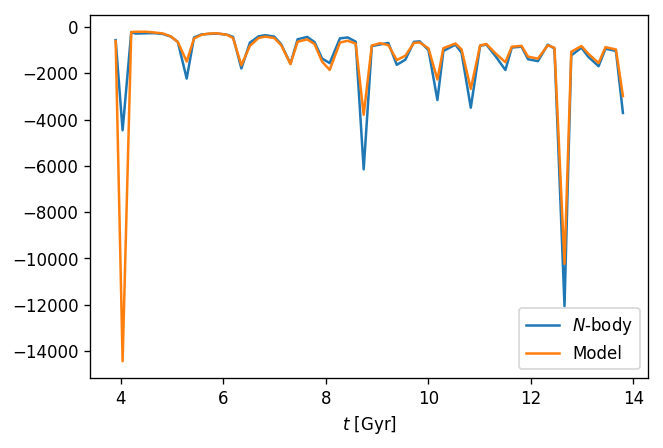

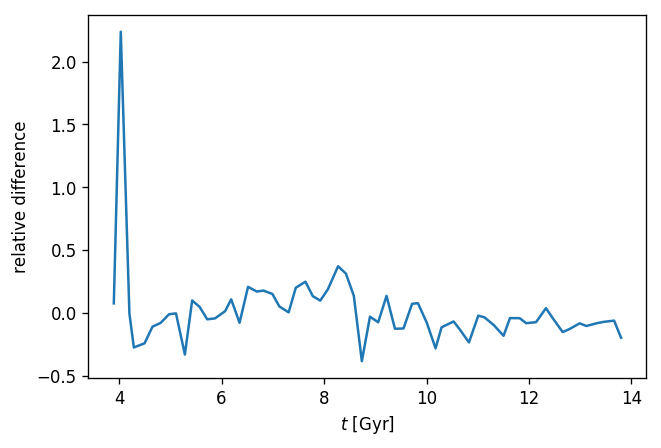

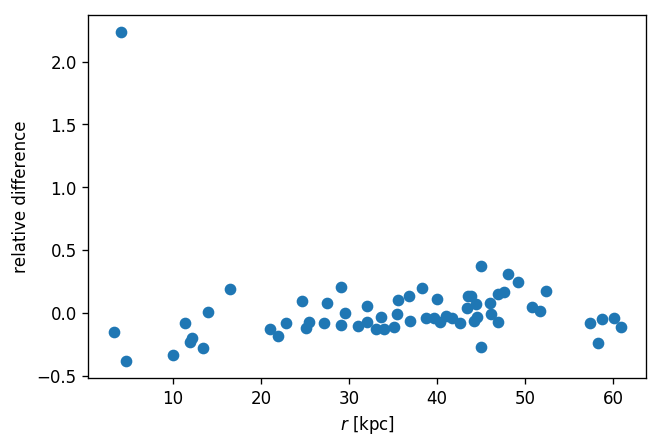

In [16]:
acc_rad_nbody = sum(acc_nbody * X_orbit_snaps, axis=1)/r
acc_rad_model = sum(acc_model * X_orbit_snaps, axis=1)/r

plot(t, acc_rad_nbody)
plot(t, acc_rad_model)
legend(('$N$-body', 'Model'))
xlabel('$t$ [Gyr]')
figure()
relative_diff = (acc_rad_model-acc_rad_nbody)/acc_rad_nbody
plot(t, relative_diff)
xlabel('$t$ [Gyr]')
ylabel('relative difference')
print('Mean deviation', mean(relative_diff[~isnan(relative_diff)]))
print('Standard deviation', std(relative_diff[~isnan(relative_diff)]))
figure()
plot(r, relative_diff, 'o')
xlabel('$r$ [kpc]')
ylabel('relative difference')

In [17]:
# without the rogue datapoint
relative_diff = relative_diff[abs(relative_diff)<1]
print('Mean deviation', mean(relative_diff[~isnan(relative_diff)]))
print('Standard deviation', std(relative_diff[~isnan(relative_diff)]))

Mean deviation -0.01941862888166185
Standard deviation 0.14968771190939506


/home/meiron/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


# Results: z-force

Mean deviation -0.17497269573813193
Standard deviation 2.4654906131204455


/home/meiron/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0, 0.5, 'relative difference')

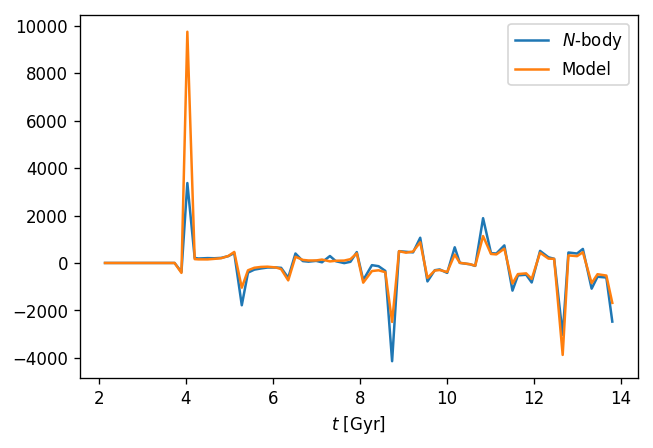

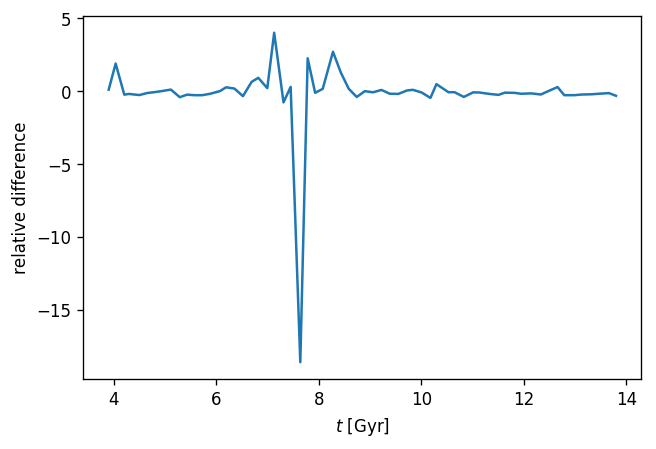

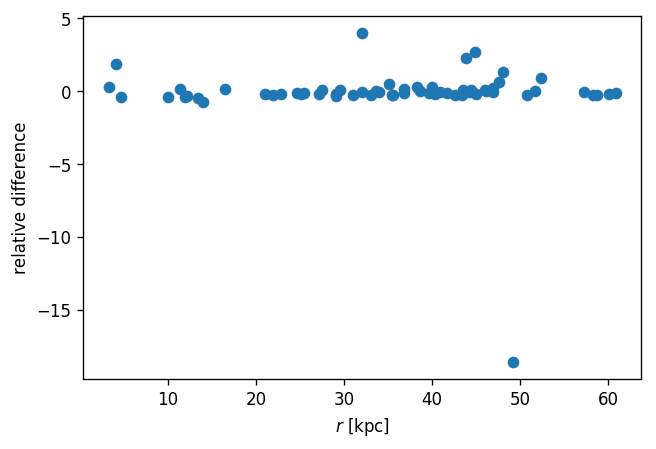

In [18]:
acc_z_nbody = acc_nbody[:,2]
acc_z_model = acc_model[:,2]

plot(t, acc_z_nbody)
plot(t, acc_z_model)
legend(('$N$-body', 'Model'))
xlabel('$t$ [Gyr]')
figure()
relative_diff = (acc_z_model-acc_z_nbody)/acc_z_nbody
plot(t, relative_diff)
xlabel('$t$ [Gyr]')
ylabel('relative difference')
print('Mean deviation', mean(relative_diff[~isnan(relative_diff)]))
print('Standard deviation', std(relative_diff[~isnan(relative_diff)]))
figure()
plot(r, relative_diff, 'o')
xlabel('$r$ [kpc]')
ylabel('relative difference')